# Harris Corner Detection

In [27]:
from skimage import data, io, filters, color
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import cv2

## Gaussian Smooth

In [9]:
def gaussian_kernel(window_size, sigma):
    N = (window_size + 1) // 2

    rhalf_kernel = np.zeros((N,))
    
    for i in range(N):
        x_n = i / sigma
        rhalf_kernel[i] = np.exp(-0.5 * x_n * x_n)

    if window_size % 2 == 0:
        lhalf_kernel = np.flip(rhalf_kernel)
    else:
        lhalf_kernel = np.flip(rhalf_kernel[1:])
        
    kernel = np.concatenate([lhalf_kernel, rhalf_kernel])
    
    kernel /= sum(kernel)
    
    return kernel

In [13]:
def gaussian_smooth1(img, k, sigma):
    kernel = gaussian_kernel(k, sigma)
    
    image = img

    for j in range(3):
        layer = image[:,:,j]

        m = layer.shape[1]
        for i in range(m):
            layer[i,:] = np.convolve(layer[i,:], kernel, mode='same')

        n = image.shape[0]
        for i in range(n):
            layer[:,i] = np.convolve(layer[:,i], kernel, mode='same')
        
        image[:,:,j] = layer
    
    return image

In [14]:
def gaussian_smooth(image, k, sigma):
    kernel = gaussian_kernel(k, sigma)
    img = np.zeros(image.shape)
    m, n = image.shape[:2]
    
    for j in range(3):
        for i in range(m):
            img[i,:,j] = np.convolve(image[i,:,j], kernel, mode='same')
        
        for i in range(n):
            img[:,i,j] = np.convolve(img[:,i,j], kernel, mode='same')
    
    return img

## Sobel Edge Detection

In [21]:
def sobel_edge_detection(image):
    image = color.rgb2gray(image)
    avg = np.array([1, 2, 1])
    diff = np.array([1, 0, -1])

    m, n = image.shape[:2]
    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)

    for i in range(m):
        gx[i,:] = np.convolve(image[i,:], diff, mode='same')
        gy[i,:] = np.convolve(image[i,:], avg, mode='same')

    for i in range(n):
        gx[:,i] = np.convolve(gx[:,i], avg, mode='same')
        gy[:,i] = np.convolve(gy[:,i], diff, mode='same')

    img = np.sqrt(gx**2 + gy**2)
    img = np.floor(img * 225.0 / np.max(img))

    return img

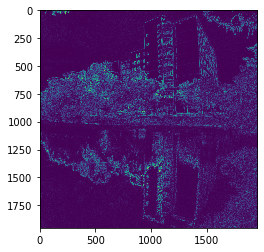

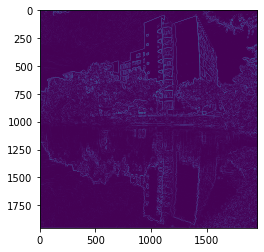

In [34]:
image = io.imread('original.jpg')
smooth_img = gaussian_smooth(image, 10, 5)

plt.figure()
plt.imshow(sobel_edge_detection(image))

plt.figure()
plt.imshow(sobel_edge_detection(smooth_img))